## Web Voyager

[WebVoyager](https://arxiv.org/abs/2401.13919) by He, et. al., is a vision-enabled web-browsing agent capable of controlling the mouse and keyboard.

It works by viewing annotated browser screenshots for each turn, then choosing the next step to take. The agent architecture is a basic reasoning and action (ReAct) loop. 
The unique aspects of this agent are:
- It's usage of [Set-of-Marks](https://som-gpt4v.github.io/)-like image annotations to serve as UI affordances for the agent
- It's application in the browser by using tools to control both the mouse and keyboard

The overall design looks like the following:

<!-- ![Voyager Image](./img/web-voyager.excalidraw.png) -->
<img src="./img/web-voyager.excalidraw.png" width="50%">


## Configure environment

We will first set up LangSmith tracing. Though optional, this lets us inspect and debug agent's trajectory for a given input.

You can sign up at [smith.langchain.com](https://smith.langchain.com/) to get an API key.

In [1]:
# %%capture --no-stderr
# %pip install -U --quiet langgraph langsmith langchain_openai

In [2]:
# Optional: add tracing to visualize the agent trajectories
import os
from getpass import getpass


def _getpass(env_var: str):
    if not os.environ.get(env_var):
        os.environ[env_var] = getpass(f"{env_var}=")


os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Web-Voyager"
_getpass("LANGCHAIN_API_KEY")
_getpass("OPENAI_API_KEY")

LANGCHAIN_API_KEY=········


#### Install Agent requirements

The only additional requirement we have is the [playwright](https://playwright.dev/) browser. Uncomment and install below:

In [3]:
# %pip install --upgrade --quiet  playwright > /dev/null
# !playwright install

In [4]:
import nest_asyncio

# This is just required for running async playwright in a Jupyter notebook
nest_asyncio.apply()

## Define Graph State

The state provides the inputs to each node in the graph.

In our case, the agent will track the webpage object (within the browser), annotated images + bounding boxes, the user's initial request, and the messages containing the agent scratchpad, system prompt, and other information.


In [5]:
from typing import List, Optional, TypedDict

from langchain_core.messages import BaseMessage, SystemMessage
from playwright.async_api import Page


class BBox(TypedDict):
    x: float
    y: float
    text: str
    type: str
    ariaLabel: str


class Prediction(TypedDict):
    action: str
    args: Optional[List[str]]


# This represents the state of the agent
# as it proceeds through execution
class AgentState(TypedDict):
    page: Page  # The Playwright web page lets us interact with the web environment
    input: str  # User request
    img: str  # b64 encoded screenshot
    bboxes: List[BBox]  # The bounding boxes from the browser annotation function
    prediction: Prediction  # The Agent's output
    # A system message (or messages) containing the intermediate steps
    scratchpad: List[BaseMessage]
    observation: str  # The most recent response from a tool
    knowledge: List[BaseMessage]  # The agent's knowledge base

## Define tools

The agent has 6 simple tools:

1. Click (at labeled box)
2. Type
3. Scroll
4. Wait
5. Go back
6. Go to search engine (Google)


We define them below here as functions:

In [6]:
import asyncio
import platform


async def click(state: AgentState):
    # - Click [Numerical_Label]
    page = state["page"]
    click_args = state["prediction"]["args"]
    if click_args is None or len(click_args) != 1:
        return f"Failed to click bounding box labeled as number {click_args}"
    bbox_id = click_args[0]
    bbox_id = int(bbox_id)
    try:
        bbox = state["bboxes"][bbox_id]
    except Exception:
        return f"Error: no bbox for : {bbox_id}"
    x, y = bbox["x"], bbox["y"]
    await page.mouse.click(x, y)
    # TODO: In the paper, they automatically parse any downloaded PDFs
    # We could add something similar here as well and generally
    # improve response format.
    return f"Clicked {bbox_id}"


async def type_text(state: AgentState):
    page = state["page"]
    type_args = state["prediction"]["args"]
    if type_args is None or len(type_args) != 2:
        return (
            f"Failed to type in element from bounding box labeled as number {type_args}"
        )
    bbox_id = type_args[0]
    bbox_id = int(bbox_id)
    bbox = state["bboxes"][bbox_id]
    x, y = bbox["x"], bbox["y"]
    text_content = type_args[1]
    await page.mouse.click(x, y)
    # Check if MacOS
    select_all = "Meta+A" if platform.system() == "Darwin" else "Control+A"
    await page.keyboard.press(select_all)
    await page.keyboard.press("Backspace")
    await page.keyboard.type(text_content)
    await page.keyboard.press("Enter")
    return f"Typed {text_content} and submitted"


async def scroll(state: AgentState):
    page = state["page"]
    scroll_args = state["prediction"]["args"]
    if scroll_args is None or len(scroll_args) != 2:
        return "Failed to scroll due to incorrect arguments."

    target, direction = scroll_args

    if target.upper() == "WINDOW":
        # Not sure the best value for this:
        scroll_amount = 500
        scroll_direction = (
            -scroll_amount if direction.lower() == "up" else scroll_amount
        )
        await page.evaluate(f"window.scrollBy(0, {scroll_direction})")
    else:
        # Scrolling within a specific element
        scroll_amount = 200
        target_id = int(target)
        bbox = state["bboxes"][target_id]
        x, y = bbox["x"], bbox["y"]
        scroll_direction = (
            -scroll_amount if direction.lower() == "up" else scroll_amount
        )
        await page.mouse.move(x, y)
        await page.mouse.wheel(0, scroll_direction)

    return f"Scrolled {direction} in {'window' if target.upper() == 'WINDOW' else 'element'}"


async def wait(state: AgentState):
    sleep_time = 5
    await asyncio.sleep(sleep_time)
    return f"Waited for {sleep_time}s."


async def go_back(state: AgentState):
    page = state["page"]
    await page.go_back()
    return f"Navigated back a page to {page.url}."


async def to_google(state: AgentState):
    page = state["page"]
    await page.goto("https://www.google.com/")
    return "Navigated to google.com."

async def add_to_knowledge_base(state: AgentState):
    state["knowledge"].append(SystemMessage(state["observation"]))
    return "Added to knowledge base."

## Define Agent

The agent is driven by a multi-modal model and decides the action to take for each step. It is composed of a few runnable objects:

1. A `mark_page` function to annotate the current page with bounding boxes
2. A prompt to hold the user question, annotated image, and agent scratchpad
3. GPT-4V to decide the next steps
4. Parsing logic to extract the action


Let's first define the annotation step:
#### Browser Annotations

This function annotates all buttons, inputs, text areas, etc. with numbered bounding boxes. GPT-4V then just has to refer to a bounding box
when taking actions, reducing the complexity of the overall task.

In [7]:
import base64

from langchain_core.runnables import chain as chain_decorator

# Some javascript we will run on each step
# to take a screenshot of the page, select the
# elements to annotate, and add bounding boxes
with open("mark_page.js") as f:
    mark_page_script = f.read()


@chain_decorator
async def mark_page(page):
    await page.evaluate(mark_page_script)
    for _ in range(10):
        try:
            bboxes = await page.evaluate("markPage()")
            break
        except Exception:
            # May be loading...
            asyncio.sleep(3)
    screenshot = await page.screenshot()
    # Ensure the bboxes don't follow us around
    await page.evaluate("unmarkPage()")
    return {
        "img": base64.b64encode(screenshot).decode(),
        "bboxes": bboxes,
    }

#### Agent definition

Now we'll compose this function with the prompt, llm and output parser to complete our agent.

In [58]:
from langchain import hub
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_openai import ChatOpenAI


async def annotate(state):
    marked_page = await mark_page.with_retry().ainvoke(state["page"])
    return {**state, **marked_page}


def format_descriptions(state):
    labels = []
    for i, bbox in enumerate(state["bboxes"]):
        text = bbox.get("ariaLabel") or ""
        if not text.strip():
            text = bbox["text"]
        el_type = bbox.get("type")
        labels.append(f'{i} (<{el_type}/>): "{text}"')
    bbox_descriptions = "\nValid Bounding Boxes:\n" + "\n".join(labels)
    return {**state, "bbox_descriptions": bbox_descriptions}

import re

def parse(text: str) -> dict:
    action_prefix = "Action: "
    action_pattern = r'Action: (.+)$'
    
    match = re.search(action_pattern, text, re.DOTALL)
    if not match:
        return {"action": None, "args": None}
    
    action_block = match.group(1).strip()
    
    # Split action and args
    split_output = action_block.split(None, 1)
    action = split_output[0]
    action_input = split_output[1] if len(split_output) > 1 else None

    # Special handling for ANSWER action
    if action == "ANSWER":
        if action_input and action_input.startswith(';'):
            action_input = [action_input[1:].strip()]
        else:
            action_input = [action_input]
    elif action_input is not None:
        action_input = [inp.strip().strip("[]") for inp in action_input.split(";")]
    
    return {"action": action, "args": action_input}

# Will need a later version of langchain to pull
# this image prompt template
prompt = hub.pull("wfh/web-voyager")

In [59]:
# %pip install -qU langchain-aws

In [60]:
from langchain_aws import ChatBedrockConverse
# llm = ChatOpenAI(model="gpt-4o", max_tokens=4096)
llm = ChatBedrockConverse(
    model="anthropic.claude-3-5-sonnet-20240620-v1:0",
    temperature=0,
    max_tokens=None,
)


agent = annotate | RunnablePassthrough.assign(
    prediction=format_descriptions | prompt | llm | StrOutputParser() | parse
)

## Define graph

We've created most of the important logic. We have one more function to define that will help us update the graph state after a tool is called.

In [61]:
import re


def update_scratchpad(state: AgentState):
    """After a tool is invoked, we want to update
    the scratchpad so the agent is aware of its previous steps"""
    old = state.get("scratchpad")
    if old:
        txt = old[0].content
        last_line = txt.rsplit("\n", 1)[-1]
        step = int(re.match(r"\d+", last_line).group()) + 1
    else:
        txt = "Previous action observations:\n"
        step = 1
    txt += f"\n{step}. {state['observation']}"

    return {**state, "scratchpad": [SystemMessage(content=txt)]}

Now we can compose everything into a graph:

In [62]:
from langchain_core.runnables import RunnableLambda

from langgraph.graph import END, StateGraph

graph_builder = StateGraph(AgentState)


graph_builder.add_node("agent", agent)
graph_builder.set_entry_point("agent")

graph_builder.add_node("update_scratchpad", update_scratchpad)
graph_builder.add_edge("update_scratchpad", "agent")

tools = {
    "Click": click,
    "Type": type_text,
    "Scroll": scroll,
    "Wait": wait,
    "GoBack": go_back,
    "Google": to_google,
}


for node_name, tool in tools.items():
    graph_builder.add_node(
        node_name,
        # The lambda ensures the function's string output is mapped to the "observation"
        # key in the AgentState
        RunnableLambda(tool) | (lambda observation: {"observation": observation}),
    )
    # Always return to the agent (by means of the update-scratchpad node)
    graph_builder.add_edge(node_name, "update_scratchpad")


def select_tool(state: AgentState):
    # Any time the agent completes, this function
    # is called to route the output to a tool or
    # to the end user.
    action = state["prediction"]["action"]
    if action == "ANSWER":
        return END
    if action == "retry":
        return "agent"
    return action


graph_builder.add_conditional_edges("agent", select_tool)

graph = graph_builder.compile()

## Run agent

Now that we've created the whole agent executor, we can run it on a few questions! We'll start our browser at "google.com" and then let it control the rest.

Below is a helper function to help print out the steps to the notebook (and display the intermediate screenshots).

In [69]:
from IPython import display
from playwright.async_api import async_playwright

browser = await async_playwright().start()
# We will set headless=False so we can watch the agent navigate the web.
browser = await browser.chromium.launch(headless=False, args=None)
page = await browser.new_page()
_ = await page.goto("https://www.google.com")


async def call_agent(question: str, page, max_steps: int = 150):
    event_stream = graph.astream(
        {
            "page": page,
            "input": question,
            "scratchpad": [],
        },
        {
            "recursion_limit": max_steps,
        },
    )
    final_answer = None
    steps = []
    async for event in event_stream:
        # We'll display an event stream here
        if "agent" not in event:
            continue
        pred = event["agent"].get("prediction") or {}
        action = pred.get("action")
        action_input = pred.get("args")
        display.clear_output(wait=False)
        steps.append(f"{len(steps) + 1}. {action}: {action_input}")
        print("\n".join(steps))
        display.display(display.Image(base64.b64decode(event["agent"]["img"])))
        if "ANSWER" in action:
            final_answer = action_input[0]
            break
    return final_answer

1. Type: ['9', 'WebVoyager paper arxiv']
2. Click: ['9']
3. Click: ['20']
4. ANSWER;: ["WebVoyager is an innovative end-to-end web agent powered by Large Multimodal Models (LMM). Key points about WebVoyager from the abstract:\n\n1. It's designed to complete user instructions by interacting with real-world websites.\n2. The authors introduce a new benchmark with tasks from 15 popular websites.\n3. They propose an automatic evaluation protocol using GPT-4's multimodal abilities.\n4. WebVoyager achieves a 59.1% task success rate on their benchmark.\n5. It significantly outperforms both GPT-4 (All Tools) and WebVoyager (text-only) setups.\n6. The proposed evaluation metric shows 85.3% agreement with human judgment.\n7. This work aims to advance autonomous applications for real-world web interactions.\n\nThe paper was submitted on 25 Jan 2024 and has been accepted to ACL 2024 (main). It represents a significant step forward in creating more capable and versatile web agents using large langu

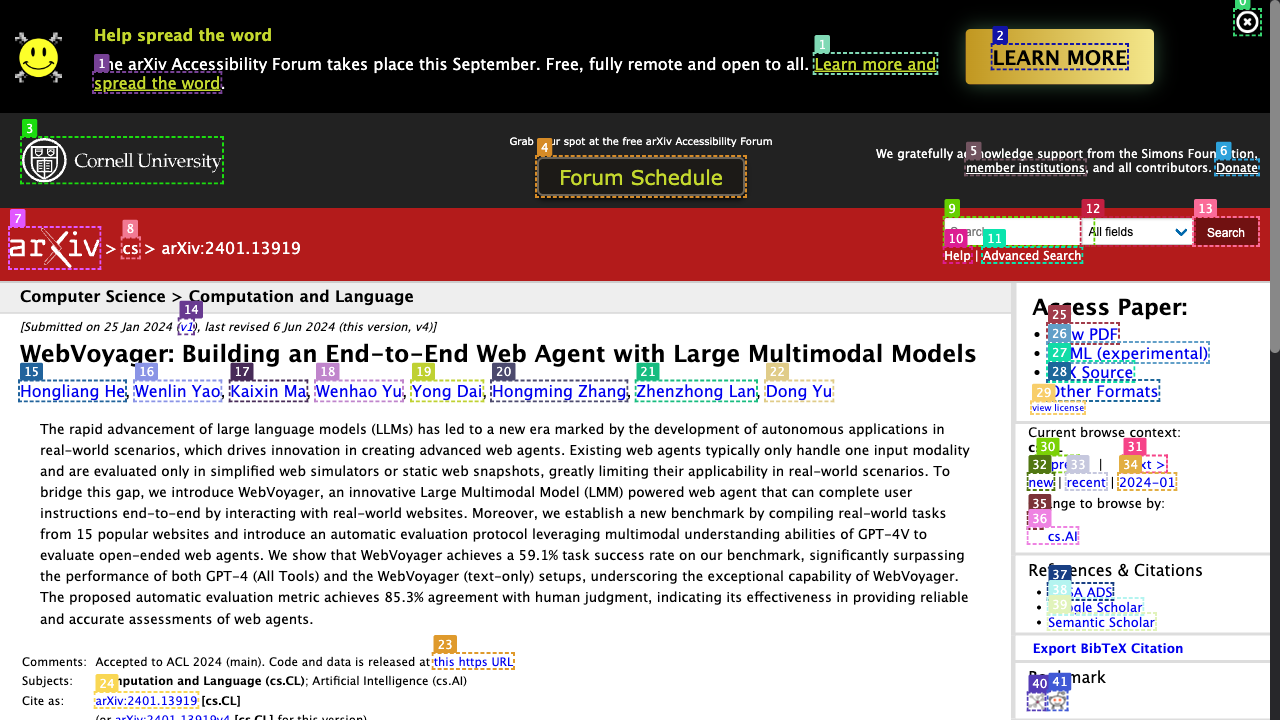

Final response: WebVoyager is an innovative end-to-end web agent powered by Large Multimodal Models (LMM). Key points about WebVoyager from the abstract:

1. It's designed to complete user instructions by interacting with real-world websites.
2. The authors introduce a new benchmark with tasks from 15 popular websites.
3. They propose an automatic evaluation protocol using GPT-4's multimodal abilities.
4. WebVoyager achieves a 59.1% task success rate on their benchmark.
5. It significantly outperforms both GPT-4 (All Tools) and WebVoyager (text-only) setups.
6. The proposed evaluation metric shows 85.3% agreement with human judgment.
7. This work aims to advance autonomous applications for real-world web interactions.

The paper was submitted on 25 Jan 2024 and has been accepted to ACL 2024 (main). It represents a significant step forward in creating more capable and versatile web agents using large language and multimodal models.


In [65]:
res = await call_agent("Could you explain the WebVoyager paper (on arxiv)?", page)
print(f"Final response: {res}")

In [66]:
res = await call_agent(
    "Please explain the today's XKCD comic for me. Why is it funny?", page
)
print(f"Final response: {res}")

Exception ignored in: <function BaseEventLoop.__del__ at 0x105693420>
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.11/3.11.9/Frameworks/Python.framework/Versions/3.11/lib/python3.11/asyncio/base_events.py", line 692, in __del__
    if not self.is_closed():
           ^^^^^^^^^^^^^^^^
  File "/opt/homebrew/Cellar/python@3.11/3.11.9/Frameworks/Python.framework/Versions/3.11/lib/python3.11/asyncio/base_events.py", line 689, in is_closed
    return self._closed
           ^^^^^^^^^^^^
AttributeError: '_UnixSelectorEventLoop' object has no attribute '_closed'
Exception ignored in: <function BaseEventLoop.__del__ at 0x105693420>
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.11/3.11.9/Frameworks/Python.framework/Versions/3.11/lib/python3.11/asyncio/base_events.py", line 692, in __del__
    if not self.is_closed():
           ^^^^^^^^^^^^^^^^
  File "/opt/homebrew/Cellar/python@3.11/3.11.9/Frameworks/Python.framework/Versions/3.11/lib/pyth

Exception ignored in: <function BaseEventLoop.__del__ at 0x105693420>
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.11/3.11.9/Frameworks/Python.framework/Versions/3.11/lib/python3.11/asyncio/base_events.py", line 692, in __del__
    if not self.is_closed():
           ^^^^^^^^^^^^^^^^
  File "/opt/homebrew/Cellar/python@3.11/3.11.9/Frameworks/Python.framework/Versions/3.11/lib/python3.11/asyncio/base_events.py", line 689, in is_closed
    return self._closed
           ^^^^^^^^^^^^
AttributeError: '_UnixSelectorEventLoop' object has no attribute '_closed'
Exception ignored in: <function BaseEventLoop.__del__ at 0x105693420>
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.11/3.11.9/Frameworks/Python.framework/Versions/3.11/lib/python3.11/asyncio/base_events.py", line 692, in __del__
    if not self.is_closed():
           ^^^^^^^^^^^^^^^^
  File "/opt/homebrew/Cellar/python@3.11/3.11.9/Frameworks/Python.framework/Versions/3.11/lib/pyth

ValueError: Branch did not return a valid destination

1. Google: None
2. Type: ['8', 'langchain latest blog posts']
3. Click: ['0']
4. Type: ['8', 'langchain latest blog posts']
5. ANSWER;: ['The latest blog posts from LangChain, based on the search results, appear to be:\n\n1. "By LangChain" - which mentions improvements to core tool interfaces.\n2. "Building applications with ..." - likely about building applications with LLMs.\n3. "LangChain v0.1.0" - announcing the release of version 0.1.0 with higher level entry points for specific chains.\n4. "LangGraph" - a blog post walking through the motivations for something called LangGraph.\n5. "LangChain v0.2: A Leap ..." - announcing version 0.2, which seems to involve new entry points.\n\nThese appear to be the most recent blog posts from LangChain based on the search results provided. The exact dates are not visible, but they are listed in order of recency according to Google\'s search algorithm.']


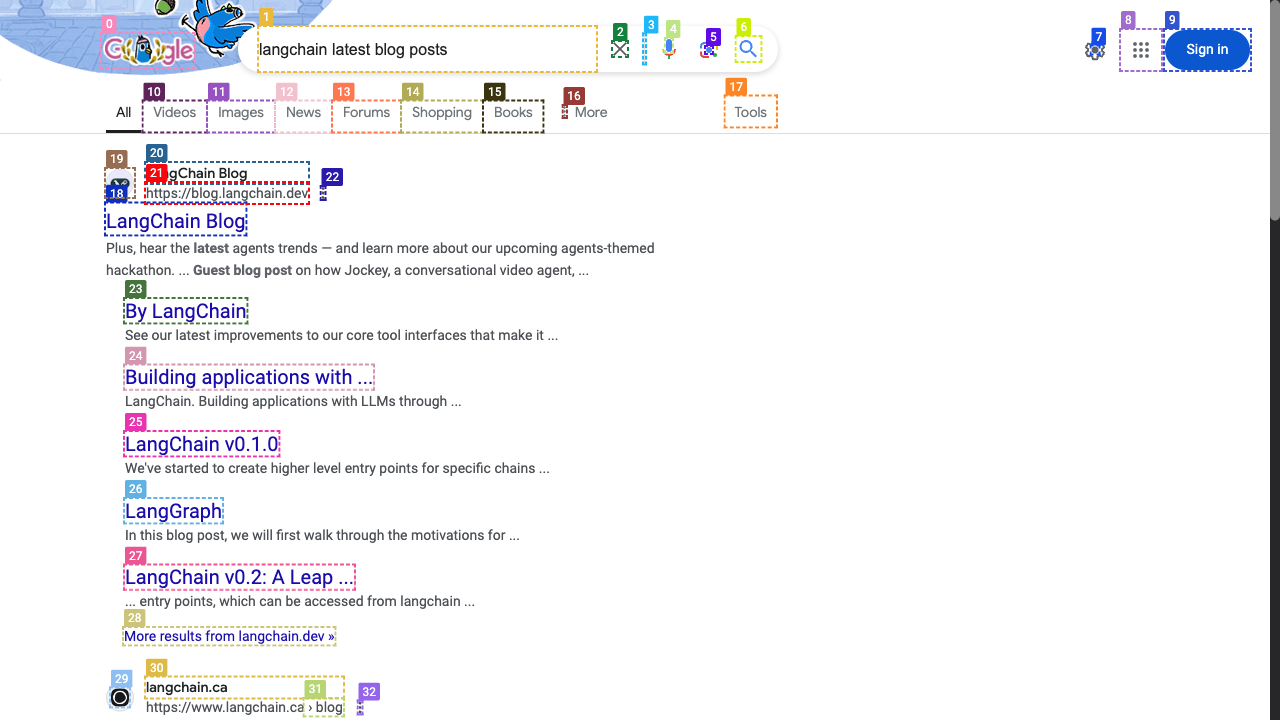

Final response: The latest blog posts from LangChain, based on the search results, appear to be:

1. "By LangChain" - which mentions improvements to core tool interfaces.
2. "Building applications with ..." - likely about building applications with LLMs.
3. "LangChain v0.1.0" - announcing the release of version 0.1.0 with higher level entry points for specific chains.
4. "LangGraph" - a blog post walking through the motivations for something called LangGraph.
5. "LangChain v0.2: A Leap ..." - announcing version 0.2, which seems to involve new entry points.

These appear to be the most recent blog posts from LangChain based on the search results provided. The exact dates are not visible, but they are listed in order of recency according to Google's search algorithm.


In [67]:
res = await call_agent("What are the latest blog posts from langchain?", page)
print(f"Final response: {res}")

In [ ]:
res = await call_agent(
    "Could you check google maps to see when i should leave to get to SFO by 7 o'clock? starting from SF downtown.",
    page,
)
print(f"Final response: {res}")

1. Type: ['9', 'Amazon Q user store']
2. Click: ['31']
3. Click: ['20']
4. Click: ['20']
5. Click: ['20']
6. Click: ['20']
7. Click: ['20']
8. Click: ['14']


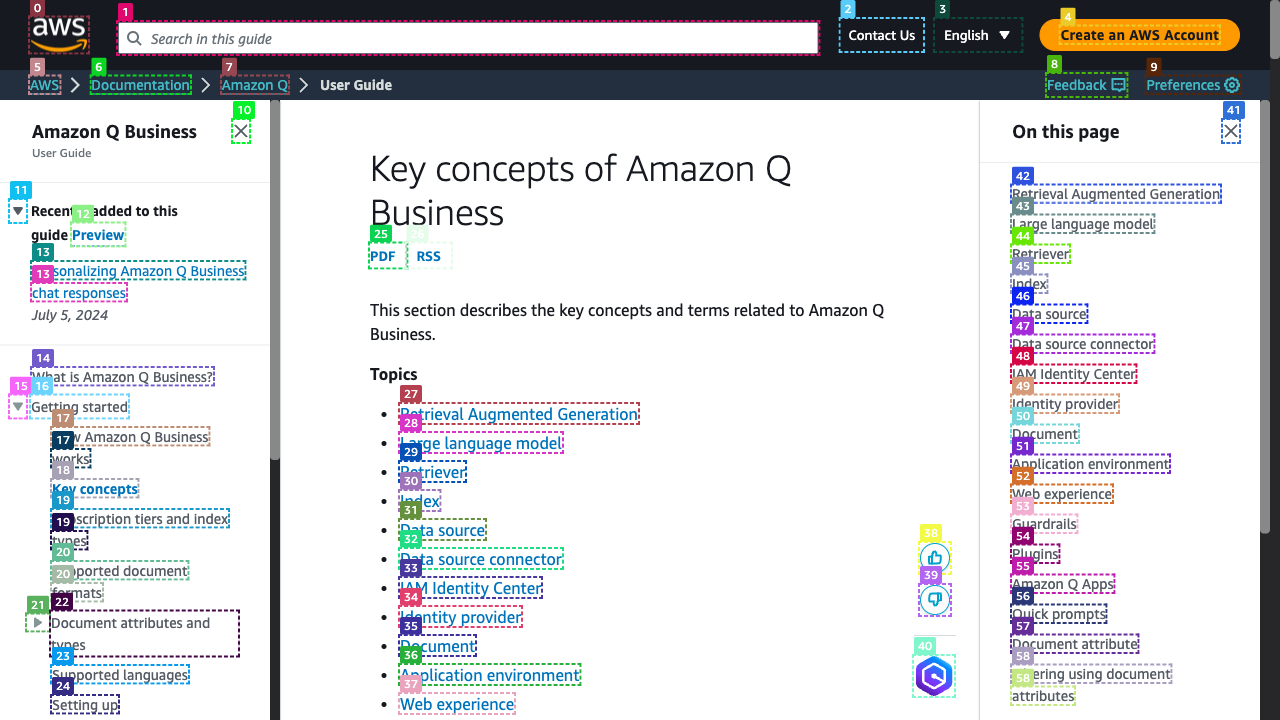

Exception ignored in: <function BaseEventLoop.__del__ at 0x105693420>
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.11/3.11.9/Frameworks/Python.framework/Versions/3.11/lib/python3.11/asyncio/base_events.py", line 692, in __del__
    if not self.is_closed():
           ^^^^^^^^^^^^^^^^
  File "/opt/homebrew/Cellar/python@3.11/3.11.9/Frameworks/Python.framework/Versions/3.11/lib/python3.11/asyncio/base_events.py", line 689, in is_closed
    return self._closed
           ^^^^^^^^^^^^
AttributeError: '_UnixSelectorEventLoop' object has no attribute '_closed'
Exception ignored in: <function BaseEventLoop.__del__ at 0x105693420>
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.11/3.11.9/Frameworks/Python.framework/Versions/3.11/lib/python3.11/asyncio/base_events.py", line 692, in __del__
    if not self.is_closed():
           ^^^^^^^^^^^^^^^^
  File "/opt/homebrew/Cellar/python@3.11/3.11.9/Frameworks/Python.framework/Versions/3.11/lib/pyth

Exception ignored in: <function BaseEventLoop.__del__ at 0x105693420>
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.11/3.11.9/Frameworks/Python.framework/Versions/3.11/lib/python3.11/asyncio/base_events.py", line 692, in __del__
    if not self.is_closed():
           ^^^^^^^^^^^^^^^^
  File "/opt/homebrew/Cellar/python@3.11/3.11.9/Frameworks/Python.framework/Versions/3.11/lib/python3.11/asyncio/base_events.py", line 689, in is_closed
    return self._closed
           ^^^^^^^^^^^^
AttributeError: '_UnixSelectorEventLoop' object has no attribute '_closed'
Exception ignored in: <function BaseEventLoop.__del__ at 0x105693420>
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.11/3.11.9/Frameworks/Python.framework/Versions/3.11/lib/python3.11/asyncio/base_events.py", line 692, in __del__
    if not self.is_closed():
           ^^^^^^^^^^^^^^^^
  File "/opt/homebrew/Cellar/python@3.11/3.11.9/Frameworks/Python.framework/Versions/3.11/lib/pyth

In [ ]:
res = await call_agent(
    "Can you please figure out what the user store is in Amazon Q?",
    page,
)
print(f"Final response: {res}")